<a href="https://colab.research.google.com/github/TobiBu/graddays/blob/main/day_2/notebooks/ULA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unadjusted Langevin Algorithm

This tutorial implements the unadjusted Langevin algorithm to sample from a SDE.

In [ ]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm


# Langevin Monte Carlo

New samples are proposed by simulating the Langevin Stochastic Differential Equation (SDE) which is given by

\begin{equation}
    dx(t) = -\nabla V(x) dt +\sqrt{2}dW_t
\end{equation}

where $V$ is the potential function and $dW_t$ is the standard Wiener process.

### Example

Let $V( {\bf x}) = \left( \frac{|{\bf x}|-2}{0.4}\right)^2 - \log \left( \exp\left[ -\frac{1}{2} \left(\frac{x_1 - 2}{0.6} \right)^2\right]+ \exp\left[ -\frac{1}{2} \left(\frac{x_1 + 2}{0.6} \right)^2\right] \right)$, and $p({\bf x})= e^{-V(x)}$ be the distribution we want to sample from.

Let's visualize the (unnormalized) density.

In [ ]:
def npdensity1(z):
    z = np.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)

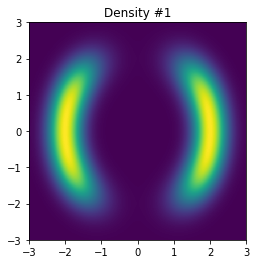

In [ ]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity1(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Density #1')
plt.show()

### Unadjusted Langevin Algorithm (ULA)

The Langevin SDE can be simulated using the Euler-Maruyama scheme as follows

\begin{equation}
     {\bf x_{n+1}} =  {\bf x_{n}} + \gamma_{n+1} \nabla V( {\bf x_{n}})  +\sqrt{2  \gamma_{n+1}} \, \xi_n\,
\end{equation}

where $\gamma_{n+1}$ is the step size and $\xi_n$ is a sample from $\mathcal{N}(0,1)$ respectively at the (n+1)-th time-step.

In [ ]:
def potential1(z):
    z = z.view(-1, 2)
    z1, z2 = z[:, 0], z[:, 1]
    norm = torch.norm(z, p=2, dim=1)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return u

In [ ]:
def unadjusted_langevin_algorithm(potential, n_samples=100000, step=0.1):
    burn_in = 10000
    Z0 = torch.randn(1, 2)
    Zi = Z0
    samples = []
    for i in tqdm(range(n_samples + burn_in)):
        Zi.requires_grad_()
        u = potential(Zi).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1, 2)
        samples.append(Zi.detach().numpy())
    return np.concatenate(samples, 0)[burn_in:]

Run the ULA and render the empirical density.

In [ ]:
samples1 = unadjusted_langevin_algorithm(potential1)

/var/folders/yd/wrwn16dn3jbd0kbrgdc6xts00000gn/T/ipykernel_68578/50480830.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_samples + burn_in)):


  0%|          | 0/110000 [00:00<?, ?it/s]

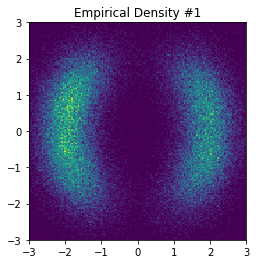

In [ ]:
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Empirical Density #1')
plt.show()